# Курсовой проект для курса "Python для Data Science"
#### Исполнитель Васильев А.

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).  
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN_DATASET_PATH = 'datasets/train.csv'
TEST_DATASET_PATH = 'datasets/test.csv'
PREDICT_PRICE_PATH  = 'datasets/AVsasilev_predictions.csv'

In [4]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "darkgrey",
    "family": "arial",
}

label_font = {
    "fontsize": 10,
    "family": "arial",
}

In [5]:
def r2_score(train_true, train_pred, test_true, test_pred):
    print('Train R2:\t' + str(round(r2(train_true, train_pred), 3)) + '\n' +
         'Test R2:\t' + str(round(r2(test_true, test_pred), 3)) + '\n')
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.scatter(x=train_true, y=train_pred)
    plt.title('Train true vs Predicted values', fontdict=title_font)
    plt.xlabel('Train predicted values', fontdict=label_font)
    plt.ylabel('Train true values', fontdict=label_font)
    
    plt.subplot(122)
    plt.scatter(x=test_true, y=test_pred)
    plt.title('Test true vs Predicted values', fontdict=title_font)
    plt.xlabel('Test predicted values', fontdict=label_font)
    plt.ylabel('Test true values', fontdict=label_font)
        
    plt.show()

### Описание датасета
1. Id - идентификационный номер квартиры
2. DistrictId - идентификационный номер района
3. Rooms - количество комнат
4. Square - площадь
5. LifeSquare - жилая площадь
6. KitchenSquare - площадь кухни
7. Floor - этаж
8. HouseFloor - количество этажей в доме
9. HouseYear - год постройки дома
10. Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
11. Social_1, Social_2, Social_3 - социальные показатели местности
12. Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
13. Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
14. Price - цена квартиры

### Загружаю датасеты

#### Train dataset

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
print(f'Форма обучающего датасета:\t{df_train.shape}')

Форма обучающего датасета:	(10000, 20)


In [7]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
print(f'Количество пропущенных значений:\n{df_train.isnull().sum()}')

Количество пропущенных значений:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64


#### Test dataset

In [10]:
df_test = pd.read_csv(TEST_DATASET_PATH)
print(f'Форма тестового датасета:\t{df_test.shape}')

Форма тестового датасета:	(5000, 19)


In [11]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [13]:
print(f'Количество пропущенных значений:\n{df_test.isnull().sum()}')

Количество пропущенных значений:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


### Обработка пропусков

#### LifeSquare

In [14]:
lsquare_median_train = round(df_train["LifeSquare"].median(), 6)
lsquare_median_test = round(df_test["LifeSquare"].median(), 6)
print(f'Медиана LifeSquare обучающего датасета:\t {lsquare_median_train}')
print(f'Медиана LifeSquare тестового датасета:\t {lsquare_median_test}')

Медиана LifeSquare обучающего датасета:	 32.78126
Медиана LifeSquare тестового датасета:	 32.925087


Пропуски заполняю медианным значением LifeSquare, если это значение меньше значения Square

In [15]:
df_train.loc[df_train['LifeSquare'].isnull() & (df_train['Square'] > lsquare_median_train), 'LifeSquare'] = lsquare_median_train

In [16]:
df_test.loc[df_test['LifeSquare'].isnull() & (df_train['Square'] > lsquare_median_test), 'LifeSquare'] = lsquare_median_test

Оставшиеся пропуски заполняю разницей Square и разницы медианных значений Square и LifeSquare, если это значение меньше значения LifeSquare

In [17]:
sub_square_train = round(df_train['Square'].median() - df_train['LifeSquare'].median(), 6)
print(f'Разница медиан Square и LifeSquare обучающего датасета:\t {sub_square_train}')

Разница медиан Square и LifeSquare обучающего датасета:	 19.73205


In [18]:
df_train.loc[df_train['LifeSquare'].isnull() & (df_train['Square'] > sub_square_train), 'LifeSquare'] = df_train['Square'] - lsquare_median_train

In [19]:
sub_square_test = round(df_test['Square'].median() - df_test['LifeSquare'].median(), 6)
print(f'Разница медиан Square и LifeSquare тестового датасета:\t {sub_square_test}')

Разница медиан Square и LifeSquare тестового датасета:	 19.996253


In [20]:
df_test.loc[df_test['LifeSquare'].isnull() & (df_test['Square'] > sub_square_test), 'LifeSquare'] = df_test['Square'] - lsquare_median_test

Последнее пустое значение обучающего датасета приравниваю к Square

In [21]:
df_train.loc[df_train['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6945,12927,62,2.0,17.414181,NaN,1.0,4,20.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,180750.471749


In [22]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['Square']

In [23]:
print(f'Количество пустых значений признака LifeSquare обучающего датасета:\t{df_train.loc[df_train["LifeSquare"].isnull(), "LifeSquare"].sum()}')
print(f'Количество пустых значений признака LifeSquare тестового датасета:\t{df_test.loc[df_test["LifeSquare"].isnull(), "LifeSquare"].sum()}')

Количество пустых значений признака LifeSquare обучающего датасета:	0.0
Количество пустых значений признака LifeSquare тестового датасета:	0.0


##### Healthcare_1

In [24]:
hc1_median_train = round(df_train["Healthcare_1"].median(), 3)
hc1_median_test = round(df_test["Healthcare_1"].median(), 3)
print(f'Медиана Healthcare_1 обучающего датасета:\t {hc1_median_train}')
print(f'Медиана Healthcare_1 тестового датасета:\t {hc1_median_test}')

Медиана Healthcare_1 обучающего датасета:	 900.0
Медиана Healthcare_1 тестового датасета:	 900.0


Пустые значения заполняю медианами

In [25]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = hc1_median_train

In [26]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = hc1_median_test

In [27]:
print(f'Количество пустых значений признака Healthcare_1 обучающего датасета:\t{df_train.loc[df_train["Healthcare_1"].isnull(), "Healthcare_1"].sum()}')
print(f'Количество пустых значений признака Healthcare_1 тестового датасета:\t{df_test.loc[df_test["Healthcare_1"].isnull(), "Healthcare_1"].sum()}')

Количество пустых значений признака Healthcare_1 обучающего датасета:	0.0
Количество пустых значений признака Healthcare_1 тестового датасета:	0.0


### Scatterplot для визуализации разброса стоимости квартир от общей площади

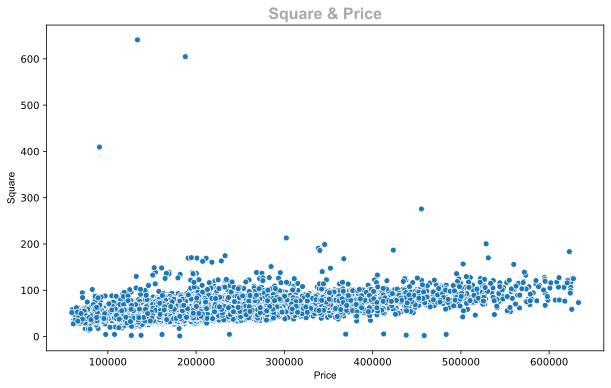

In [28]:
plt.figure(figsize=(10,6))

sns.scatterplot(x=df_train['Price'], y=df_train['Square'])

plt.title('Square & Price', fontdict=title_font)
plt.ylabel('Square', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.show()

### Обработка выбросов обучающего датасета

In [29]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.130546,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.647075,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,-6.228072,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.165748,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Rooms
Значениям больше 10 и равные 0 присваиваю значение медианы

In [30]:
df_train.loc[(df_train['Rooms'] > 10) | (df_train['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,900.0,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,32.781260,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,32.781260,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,32.781260,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [31]:
df_train.loc[(df_train['Rooms'] > 10) | (df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].median()

#### Square
Значениям больше 200 или меньше 15 присваиваю значение произведения количества комнат квартиры и средней общей площади квартиры с 1 комнатой

In [32]:
averange_square_per_room = round(df_train['Square'].mean() / df_train['Rooms'].mean(), 6)
print(f'Средняя общая площадь квартиры с 1 комнатой:\t{averange_square_per_room}')

Средняя общая площадь квартиры с 1 комнатой:	29.790402


In [33]:
df_train.loc[(df_train['Square'] > 200) | (df_train['Square'] < 15), 'Square'] = df_train['Rooms'] * averange_square_per_room

#### LifeSquare
Значениям больше Square и меньше либо равным 10 присваиваю значение разности Square и sub_square_train  
Получившиеся отрицательные или равные нулю значения заполняю значением медианы

In [34]:
# Данные значения заполняю разностью Square и sub_square_train
df_train.loc[(df_train['LifeSquare'] > df_train['Square']) | (df_train['LifeSquare'] <= 10), 'LifeSquare'] = df_train['Square'] - sub_square_train

In [35]:
# Отрицательным значениям присваиваю среднее значения для квартир с общей площадью до 20 м2
df_train.loc[df_train['LifeSquare'] <= 0, 'LifeSquare'] = df_train.loc[df_train['LifeSquare'] <= 20, 'LifeSquare'].mean()

#### KitchenSquare
Значениям более 150 или менее 5 присваиваю значение медианы

In [36]:
df_train.loc[(df_train['KitchenSquare'] > 150) | (df_train['KitchenSquare'] <= 5), 'KitchenSquare'] = df_train['KitchenSquare'].median()

#### HouseYear

In [37]:
df_train.loc[df_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,6.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [38]:
df_train.loc[df_train['HouseYear'] == 20052011.0, 'HouseYear'] = 2005

In [39]:
df_train.loc[df_train['HouseYear'] == 4968.0, 'HouseYear'] = 1968

#### HouseFloor
Значения меньше этажа, на которой находится квартира, заменяю на разность медиан HouseFloor и Floor

In [40]:
df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'HouseFloor'] = df_train['HouseFloor'].median() - df_train['Floor'].median()

In [41]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890400,56.185769,34.964274,7.657200,8.526700,12.575600,1984.865700,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.820156,18.870251,14.230940,3.901334,5.241148,6.251399,18.411517,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,16.117154,6.821138,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.783182,24.968112,6.000000,4.000000,6.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.537977,32.781260,6.000000,7.000000,12.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.894295,40.689342,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,10.000000,198.930182,161.504222,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка выбросов тестового датасета

In [42]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,35.433700,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,16.000098,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,-2.042510,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.441819,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,41.908732,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Rooms
Значения более 10 и равные 0 заполняю значением медианы

In [43]:
df_test.loc[(df_test['Rooms'] > 10) | (df_test['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [44]:
df_test.loc[(df_test['Rooms'] > 10) | (df_test['Rooms'] == 0), 'Rooms'] = df_test['Rooms'].median()

#### Square
Значениям больше 200 или меньше 15 присваиваю значение произведения количества комнат квартиры и средней общей площади квартиры с 1 комнатой

In [45]:
averange_square_per_room = round(df_test['Square'].mean() / df_test['Rooms'].mean(), 6)
print(f'Средняя общая площадь квартиры с 1 комнатой:\t{averange_square_per_room}')

Средняя общая площадь квартиры с 1 комнатой:	29.588794


In [46]:
df_test.loc[(df_test['Square'] > 200) | (df_test['Square'] < 15), 'Square'] = df_test['Rooms'] * averange_square_per_room

#### LifeSquare
Значениям больше Square и меньше либо равным 10 присваиваю значение разности Square и sub_square_train  
Получившиеся отрицательные или равные нулю значения заполняю средним значением для квартир с общей площадью до 20 м2 

In [47]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square']) | (df_test['LifeSquare'] <= 10), 'LifeSquare'] = df_test['Square'] - sub_square_test

In [48]:
df_test.loc[df_test['LifeSquare'] <= 0, 'LifeSquare'] = df_test.loc[df_test['LifeSquare'] <= 20, 'LifeSquare'].mean()

#### KitchenSquare
Значениям более 10 или менее 4 присваиваю значение медианы

In [49]:
df_test.loc[(df_test['KitchenSquare'] > 130) | (df_test['KitchenSquare'] <= 4), 'KitchenSquare'] = df_test['KitchenSquare'].median()

#### HouseFloor
Значения меньше этажа, на которой находится квартира, заменяю на разность медиан HouseFloor и Floor

In [50]:
df_test.loc[df_test['HouseFloor'] < df_test['Floor'], 'HouseFloor'] = df_test['HouseFloor'].median() - df_test['Floor'].median()

In [51]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.90780,56.468159,35.140302,7.465200,8.632000,12.324600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.81008,18.780841,14.163037,3.608849,5.483228,6.469065,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,1.00000,16.319015,6.723470,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.00000,41.912403,25.176740,6.000000,4.000000,5.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.00000,52.924953,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.00000,66.285129,41.221615,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,6.00000,189.679576,148.732782,112.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Обрабатываю object-признаки

#### Обучающий датасет

In [52]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [53]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [54]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [55]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Заменяю категориальные признаки бинарными данными

In [56]:
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A':0, 'B':1})

Изменяю тип признака `Id` на `str`

In [57]:
df_train['Id'] = df_train['Id'].astype(str)

In [58]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1,1,1


In [59]:
df_train.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
Ecology_2_bin      int64
Ecology_3_bin      int64
Shops_2_bin        int64
dtype: object

#### Тестовый датасет

Заменяю категориальные признаки бинарными данными

In [60]:
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1}).astype(int)

Изменяю тип признака `Id` на `str`

In [61]:
df_train['Id'] = df_train['Id'].astype(str)

In [62]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263183,32.925087,6.0,6,5.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,29.588794,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A,1,1,0


### Добавляю дополнительные признаки

#### Признаки:  
- DistrictSize - размер района  
- IsDistrictLarge - бинарный признак, указывающий является ли данный район большим или нет

##### Обучающий датасет

In [63]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [64]:
district_size_train = df_train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size_train.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [65]:
df_train = df_train.merge(district_size_train, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,1,1,1,87
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,1,1,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,1,1,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1,1,1,97


In [66]:
(df_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [67]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

In [68]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,1,1,1,22,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,1,1,1,87,0
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,1,1,1,174,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,1,1,1,179,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1,1,1,97,0


##### Тестовый датасет

In [69]:
df_test['DistrictId'].value_counts()

27     391
1      344
23     264
6      257
9      132
      ... 
212      1
208      1
204      1
200      1
193      1
Name: DistrictId, Length: 201, dtype: int64

In [70]:
district_size_test = df_test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size_test.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [71]:
df_test = df_test.merge(district_size_test, on='DistrictId', how='left')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B,1,1,1,91
1,15856,74,2.0,69.263183,32.925087,6.0,6,5.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,1,1,1,61
2,5480,190,1.0,29.588794,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A,1,1,0,391


In [72]:
(df_test['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [73]:
df_test['IsDistrictLarge'] = (df_test['DistrictSize'] > 100).astype(int)

In [74]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B,1,1,1,91,0
1,15856,74,2.0,69.263183,32.925087,6.0,6,5.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,1,1,1,61,0
2,5480,190,1.0,29.588794,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,1,1,1,2,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B,1,1,1,49,0
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A,1,1,0,391,1


#### MedPriceByDistrict  - медиана стоимости квартир по районам

#### Обучающий датасет

In [75]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [76]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,1,1,1,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,1,1,1,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,1,1,1,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1,1,1,97,0,158539.052715


##### Переношу признак на тестовый датасет

In [77]:
df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

Пустые значения заполняю медианами MedPriceByDistrict районов аналогичного размера

In [78]:
for i in df_test.index[df_test['MedPriceByDistrict'].isnull()]:
    district_size = df_test.iloc[i, 22]
    df_test.iat[i, 24] = df_test.loc[(df_test['DistrictSize'] == district_size) & (~df_test['MedPriceByDistrict'].isnull()), 'MedPriceByDistrict'].median()

In [79]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

### Визуализация обучающего датасета

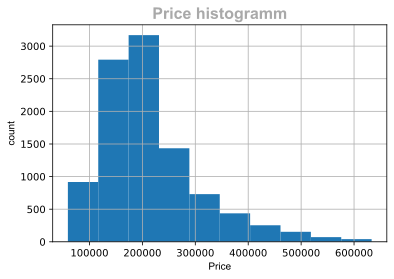

In [80]:
plt.figure(figsize=(6,4))
df_train['Price'].hist()  

plt.title('Price histogramm', fontdict=title_font)
plt.ylabel('count', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.show()

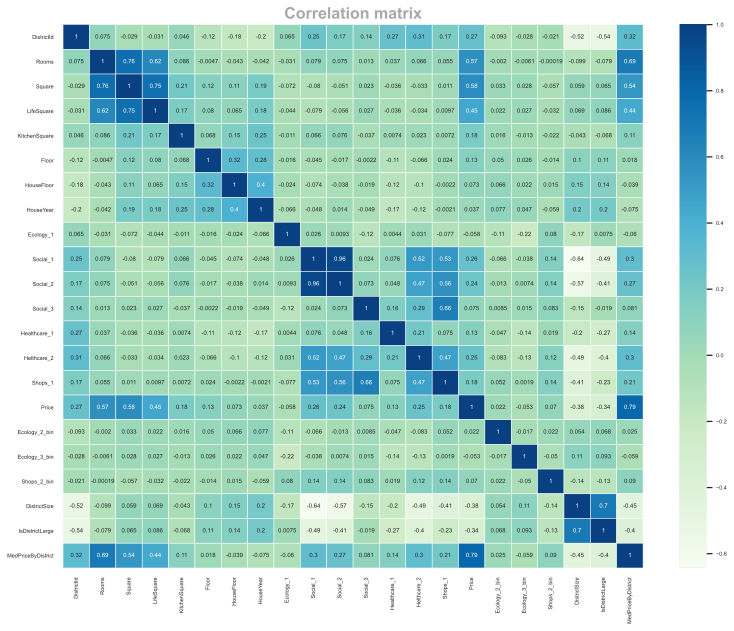

In [81]:
plt.figure(figsize = (13,10))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontdict=title_font)

plt.show()

### Стандартизирую признаки

#### Обучающий датасет

In [82]:
df_train.dtypes

Id                     object
DistrictId              int64
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Ecology_2              object
Ecology_3              object
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Shops_2                object
Price                 float64
Ecology_2_bin           int64
Ecology_3_bin           int64
Shops_2_bin             int64
DistrictSize            int64
IsDistrictLarge         int32
MedPriceByDistrict    float64
dtype: object

In [83]:
columns_for_stand = df_train.columns[:19]

In [84]:
columns_for_stand = df_train[columns_for_stand].select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_for_stand.append('DistrictSize')
columns_for_stand.append('MedPriceByDistrict')
columns_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'DistrictSize',
 'MedPriceByDistrict']

In [85]:
scaler = StandardScaler()
standard_features = scaler.fit_transform(df_train[columns_for_stand])

In [86]:
df_train_scaled = df_train.copy()
df_train_scaled[columns_for_stand] = pd.DataFrame(standard_features, columns=columns_for_stand)

In [87]:
df_train_scaled.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,-0.353348,0.133640,-0.434791,-0.388014,-0.424799,-0.291306,-0.571997,-0.861770,-0.250529,B,B,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,B,184966.930730,1,1,1,-0.819047,0,-0.048660
1,15053,-0.215687,1.352982,0.503350,0.357357,0.087872,-0.291306,-0.571997,-0.372921,-0.998053,B,B,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,B,300009.450063,1,1,1,-0.577393,0,1.156099
2,4765,0.059635,0.133640,-0.595561,-0.405240,-0.424799,-0.100498,-0.092080,-0.916087,-0.581588,B,B,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,B,220925.908524,1,1,1,-0.253948,1,0.675320
3,5809,0.174352,0.133640,-0.150127,1.248556,0.344207,-0.100498,0.707781,-0.427238,2.680470,B,B,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,B,175616.227217,1,1,1,-0.235359,1,-0.583956
4,10783,1.115034,-1.085702,-0.876374,-0.786221,-0.168464,0.471924,-0.092080,-0.481554,-0.894969,B,B,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,B,150226.531644,1,1,1,-0.540215,0,-0.691999


In [88]:
df_train_scaled.std()

DistrictId                1.000050
Rooms                     1.000050
Square                    1.000050
LifeSquare                1.000050
KitchenSquare             1.000050
Floor                     1.000050
HouseFloor                1.000050
HouseYear                 1.000050
Ecology_1                 1.000050
Social_1                  1.000050
Social_2                  1.000050
Social_3                  1.000050
Healthcare_1              1.000050
Helthcare_2               1.000050
Shops_1                   1.000050
Price                 92872.293865
Ecology_2_bin             0.098015
Ecology_3_bin             0.163543
Shops_2_bin               0.275139
DistrictSize              1.000050
IsDistrictLarge           0.499977
MedPriceByDistrict        1.000050
dtype: float64

#### Тестовый датасет

In [89]:
standard_features_test = scaler.transform(df_test[columns_for_stand])

In [90]:
df_test_scaled = df_test.copy()
df_test_scaled[columns_for_stand] = pd.DataFrame(standard_features_test, columns=columns_for_stand)

In [91]:
df_test_scaled.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,0.174352,0.133640,-0.334041,-0.107622,-0.424799,-0.482113,0.227864,-0.698820,1.607652,B,B,-0.780698,-0.649967,-0.295384,-0.169240,-0.883480,-0.880402,B,1,1,1,-0.562522,0,-0.583956
1,15856,0.541447,0.133640,0.693052,-0.143300,-0.424799,-0.482113,-1.211885,-0.427238,-0.361948,B,B,-1.065895,-0.977177,-0.211458,-0.169240,-0.883480,-0.464264,B,1,1,1,-0.674054,0,0.411771
2,5480,3.202888,-1.085702,-1.409536,-1.336312,1.113213,-1.245343,-1.211885,-4.120763,-0.998641,B,B,0.303050,0.545561,3.313409,4.923005,2.464303,0.159943,B,1,1,1,-0.893402,0,1.131166
3,15664,-0.078026,0.133640,0.893559,1.192993,0.344207,2.570806,1.507642,1.202259,-0.142708,B,B,-0.096225,-0.191973,-0.211458,-0.169240,1.125190,-0.256195,B,1,1,1,-0.718667,0,0.139996
4,14275,-0.536895,-1.085702,-0.458875,0.591930,-0.424799,1.616769,0.707781,1.745424,-0.392373,B,B,-1.294053,-1.178844,-0.295384,-0.169240,-0.883480,-0.880402,A,1,1,0,0.552806,1,-1.217308


In [92]:
df_test_scaled.std()

Id                    4832.674037
DistrictId               1.013630
Rooms                    0.987765
Square                   0.995312
LifeSquare               0.995278
KitchenSquare            0.925076
Floor                    1.046241
HouseFloor               1.034871
HouseYear                1.008829
Ecology_1                1.008826
Social_1                 1.000026
Social_2                 1.004996
Social_3                 1.001388
Healthcare_1             1.026747
Helthcare_2              0.990903
Shops_1                  0.994021
Ecology_2_bin            0.097518
Ecology_3_bin            0.170052
Shops_2_bin              0.275001
DistrictSize             0.473575
IsDistrictLarge          0.468422
MedPriceByDistrict       0.951524
dtype: float64

### Удаляю object-признаки

#### Обучающий датасет

In [93]:
feature_names = df_train_scaled[df_train.columns].select_dtypes(include=['float64', 'int64', 'uint8']).columns.tolist()
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'MedPriceByDistrict']

In [94]:
df_train_prepared = df_train_scaled[feature_names]
df_train_prepared.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,-0.353348,0.133640,-0.434791,-0.388014,-0.424799,-0.291306,-0.571997,-0.861770,-0.250529,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,184966.930730,1,1,1,-0.819047,-0.048660
1,-0.215687,1.352982,0.503350,0.357357,0.087872,-0.291306,-0.571997,-0.372921,-0.998053,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,300009.450063,1,1,1,-0.577393,1.156099
2,0.059635,0.133640,-0.595561,-0.405240,-0.424799,-0.100498,-0.092080,-0.916087,-0.581588,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,220925.908524,1,1,1,-0.253948,0.675320
3,0.174352,0.133640,-0.150127,1.248556,0.344207,-0.100498,0.707781,-0.427238,2.680470,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,175616.227217,1,1,1,-0.235359,-0.583956
4,1.115034,-1.085702,-0.876374,-0.786221,-0.168464,0.471924,-0.092080,-0.481554,-0.894969,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,150226.531644,1,1,1,-0.540215,-0.691999


#### Тестовый датасет

In [95]:
type(feature_names)

list

In [96]:
feature_names.remove('Price')
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'MedPriceByDistrict']

In [97]:
#df_test_prepared = df_test_scaled.loc[:, (df_test_scaled.columns != 'Ecology_2') & (df_test_scaled.columns != 'Ecology_3') & (df_test_scaled.columns != 'Shops_2')]
df_test_prepared = df_test_scaled[feature_names]
df_test_prepared.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,0.174352,0.133640,-0.334041,-0.107622,-0.424799,-0.482113,0.227864,-0.698820,1.607652,-0.780698,-0.649967,-0.295384,-0.169240,-0.883480,-0.880402,1,1,1,-0.562522,-0.583956
1,0.541447,0.133640,0.693052,-0.143300,-0.424799,-0.482113,-1.211885,-0.427238,-0.361948,-1.065895,-0.977177,-0.211458,-0.169240,-0.883480,-0.464264,1,1,1,-0.674054,0.411771
2,3.202888,-1.085702,-1.409536,-1.336312,1.113213,-1.245343,-1.211885,-4.120763,-0.998641,0.303050,0.545561,3.313409,4.923005,2.464303,0.159943,1,1,1,-0.893402,1.131166
3,-0.078026,0.133640,0.893559,1.192993,0.344207,2.570806,1.507642,1.202259,-0.142708,-0.096225,-0.191973,-0.211458,-0.169240,1.125190,-0.256195,1,1,1,-0.718667,0.139996
4,-0.536895,-1.085702,-0.458875,0.591930,-0.424799,1.616769,0.707781,1.745424,-0.392373,-1.294053,-1.178844,-0.295384,-0.169240,-0.883480,-0.880402,1,1,0,0.552806,-1.217308


### Разбиваю обучающий датасет на train и valid

In [98]:
X = df_train_prepared.loc[:, df_train_prepared.columns != 'Price']
y = df_train_prepared.loc[:, df_train_prepared.columns == 'Price']

In [99]:
print(f'Признаки датасета X:\t{X.columns.tolist()}')

Признаки датасета X:	['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'DistrictSize', 'MedPriceByDistrict']


In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=27)

### Обучаю модель GradientBoostingRegressor

Использую GradientBoostingRegressor т.к. она показала наилучший результат по сравнению с другими моделями регресии

In [101]:
final_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=27)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=27)

Train R2:	0.914
Test R2:	0.77



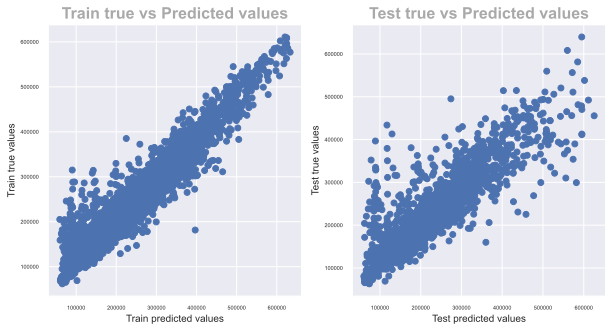

In [102]:
y_train_preds = final_model.predict(X_train)
y_valid_preds = final_model.predict(X_valid)
r2_score(y_train, y_train_preds, y_valid, y_valid_preds)

### Важность признаков

In [103]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head()

,feature_name,importance
19,MedPriceByDistrict,0.642139
2,Square,0.142884
7,HouseYear,0.027843
18,DistrictSize,0.022028
4,KitchenSquare,0.022024


### Делаю предсказание на тестовом датасете

In [104]:
test_preds = final_model.predict(df_test_prepared)

##### Поле `Id` и предсказанное поле `Price` представляю в виде датасета

In [105]:
predict_price = pd.DataFrame(df_test['Id'])

In [106]:
predict_price['Price'] = test_preds

In [107]:
print(f'Форма массива с предсказанной ценой:\t{predict_price.shape}')

Форма массива с предсказанной ценой:	(5000, 2)


In [108]:
predict_price.head(10)

,Id,Price
0,725,159875.385589
1,15856,233105.419675
2,5480,201224.987742
3,15664,377951.083976
4,14275,141162.570455
5,7633,218230.229347
6,13329,165571.996300
7,5502,224757.036844
8,4220,308936.749731
9,11538,197550.196402


#### Гистограмма с ценами квартир из обучающего датасета в сравнении с предсказанными моделью

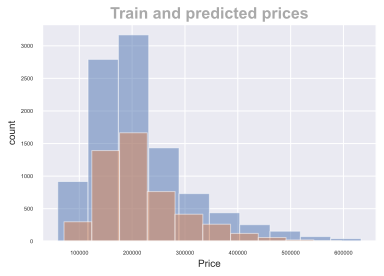

In [109]:
plt.figure(figsize=(6,4))
df_train['Price'].hist(alpha=0.5)
predict_price['Price'].hist(alpha=0.5)

plt.title('Train and predicted prices', fontdict=title_font)
plt.ylabel('count', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.show()

### Перекрёстная проверка

In [110]:
cv_score = cross_val_score(final_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score

array([0.75465287, 0.77478215, 0.71657709, 0.76238277, 0.78223193])

In [111]:
print('Среднее значение: ', cv_score.mean())
print('Стандартное отклонение: ', cv_score.std())
print('Среднее + отклонение: ', cv_score.mean() - cv_score.std())
print('Среднее - отклонение: ', cv_score.mean() + cv_score.std())

Среднее значение:  0.7581253608693588
Стандартное отклонение:  0.022869270577359158
Среднее + отклонение:  0.7352560902919996
Среднее - отклонение:  0.780994631446718


### Сохраняю получившийся датасет в файл .csv

In [112]:
predict_price.to_csv(PREDICT_PRICE_PATH, index=False, encoding='utf-8')